
# Project: Investigate a Dataset (TMDb movie data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In that study, the dataset of the movies released between 1966 and 2015 will be investigated by considering the user/watcher ratings and profits to the movie makers depending on the movie genres. Additionally, the popularity of the genres between around 10000 movies will be demonstrated from past to today 49 years along in the light of the .csv document obtained from Kaggle. 

The analysis will focus on finding the answers to the question below:

    1. How does the amount of the movies change from past to today?
    2. How does the runtime change year by year?
    3. Which genres are preferred to be filmed mostly? How does the genre distribution change among the top rated films?
    4. What is the relation between budget and profit in movie sector?

Let' s start by adding the libraries for panda, numpy and matplot which are required to investigate the .csv dataset. This will enable us to analyze the data and visualize the findings to give answers to the questions above. 


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling


### General Properties

Hier first, we read the already uploaded TMDB movie dataset .csv file and check how the read document seem with "df.head" command.

In [135]:
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


Then, let's check how do the entire data specs regarding the rows and columns look like.

In [7]:
df.shape

(10866, 21)

Also double checked from .csv file and confirmed that dataset provides information of 10866 lines and 21 columns. So, 
jupiter notebook has extracted the data succesfully.

In order to achieve some quick approach to overall data, description has been generated as following:

In [19]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


The data belonging to the "runtime, genres, vote_average, release_year, budget_adj and revenue_adj" columns are extremely important for this analysis since that informations are directly required to answer the investigated questions. 

Let' s check if there is null object or some other obstacle to clear analysis like dublications etc.

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

As seen above, some of the unnecessary information for this investigation is missing. Anyway, these data will be removed in the next section.

In [137]:
df.duplicated().sum()

1

There is also a duplicated line in dataset. 

<a id='eda'></a>
### Data Cleaning

Let's start by getting rid of duplicant data and afterwards redundant data for our analysis:

In [138]:
df.drop_duplicates(inplace = True)

In [139]:
df.drop(['id','popularity','budget','revenue','original_title','cast','homepage','director','tagline',
         'keywords','overview','production_companies','release_date','vote_count'], axis = 1, inplace = True)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 7 columns):
imdb_id         10855 non-null object
runtime         10865 non-null int64
genres          10842 non-null object
vote_average    10865 non-null float64
release_year    10865 non-null int64
budget_adj      10865 non-null float64
revenue_adj     10865 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 679.1+ KB


Only some of the imdb_id & genres data seems missing. Let's drop some of lines that corrupts the dataset.

In [141]:
df.dropna(axis=0, inplace=True, subset = ['genres'])

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842 entries, 0 to 10865
Data columns (total 7 columns):
imdb_id         10834 non-null object
runtime         10842 non-null int64
genres          10842 non-null object
vote_average    10842 non-null float64
release_year    10842 non-null int64
budget_adj      10842 non-null float64
revenue_adj     10842 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 677.6+ KB


We got cleared the data from the missing genre information and now only some of imdb_ids are missing. 
Fortunately, that will not inhibit any process of the analysis in our investigation. 

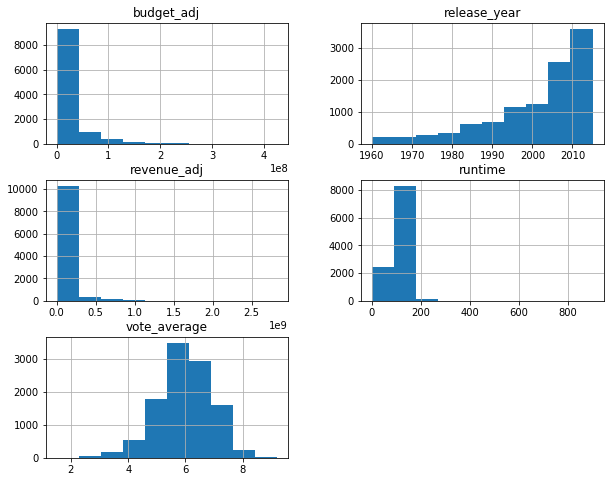

In [145]:
df.hist(figsize=(10,8));

Now, the refined and clear data is ready to be investigated.

<a id='eda'></a>
## Exploratory Data Analysis


### Q1. How does the amount of the movies change from past to today?

In order to understand correlation between year and total released movie amount in that year, the movies should be counted according to release year information

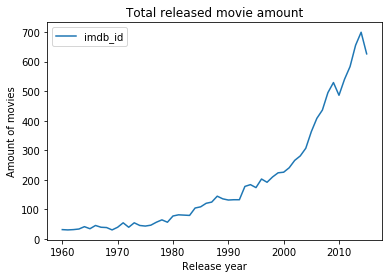

In [146]:
df.groupby('release_year').count()['imdb_id'].plot()
plt.title ('Total released movie amount')
plt.xlabel('Release year')
plt.ylabel('Amount of movies')
plt.legend();

It is demonstrated through the plot graph, that the released movie amount increased drastically espacially recent years. Let's explore the data precisely:

In [147]:
df.groupby('release_year').count()['imdb_id'].tail()

release_year
2011    540
2012    583
2013    655
2014    699
2015    626
Name: imdb_id, dtype: int64

The year 2014 has been generous from the "movie release" point of view. At that year, 699 year have been released totally. The movie sector has been developed certainly in last 15 years so that annual release amounts in 2010's are 3 times more than releases in 2000's averagely.

### Q2. How does the runtime change year by year?

Let's investigate the runtime trend until today.

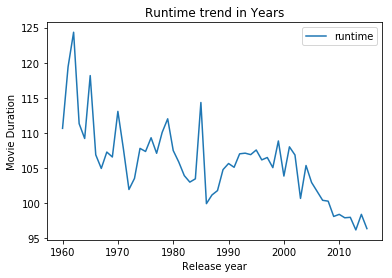

In [148]:
df.groupby('release_year').mean()['runtime'].plot()
plt.title ('Runtime trend in Years')
plt.xlabel('Release year')
plt.ylabel('Movie Duration')
plt.legend();

This graph shows that movies are getting shorter in years. A social deduction from that finding would be that 
the movie makers are more likely to shape the film durations to keep the movie-lovers' interest alive. New trend for movie duration is less than 100 minutes to avoid being boring.

### Q3. Which genres are preferred to be filmed mostly? How does the genre distribution change among the top rated films?

First we need to get rid of the columns that include data seperated with "|"

In [149]:
def seperatorless(column):
    seperated_df = df[column].str.cat(sep = '|')
    seperated_df = pd.Series(seperated_df.split('|'))
    amount = seperated_df.value_counts(ascending = False)
    return amount

In [150]:
amount_of_genres = seperatorless('genres')
amount_of_genres.head(10)

Drama              4760
Comedy             3793
Thriller           2907
Action             2384
Romance            1712
Horror             1637
Adventure          1471
Crime              1354
Family             1231
Science Fiction    1229
dtype: int64

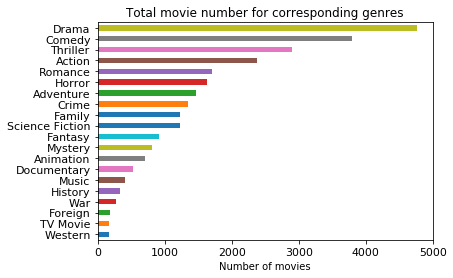

In [151]:
amount_of_genres.sort_values(ascending = True, inplace = True)
genre_plot = amount_of_genres.plot(kind = 'barh',fontsize = 11)
genre_plot.set_xlabel('Number of movies')
genre_plot.set(title = 'Total movie number for corresponding genres')
plt.figure
plt.show();

In [152]:
best_rated_movies = df.query('vote_average>8')

In [153]:
best_rated_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 441 to 10222
Data columns (total 7 columns):
imdb_id         51 non-null object
runtime         52 non-null int64
genres          52 non-null object
vote_average    52 non-null float64
release_year    52 non-null int64
budget_adj      52 non-null float64
revenue_adj     52 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.2+ KB


In [154]:
def bestrated_without_seperators(column):
    bestrated_df = best_rated_movies[column].str.cat(sep = '|')
    bestrated_df = pd.Series(bestrated_df.split('|'))
    amount = bestrated_df.value_counts(ascending = False)
    return amount

In [155]:
amount_of_bestratedgenres = bestrated_without_seperators('genres')
amount_of_bestratedgenres.head(10)

Documentary    22
Drama          16
Music          15
Comedy          9
Crime           7
Thriller        4
Romance         3
Animation       3
Horror          2
Action          2
dtype: int64

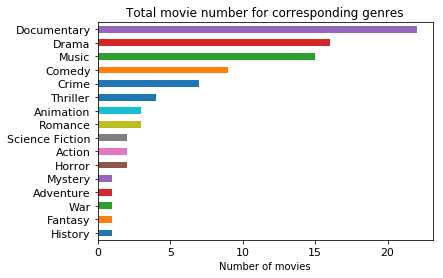

In [156]:
amount_of_bestratedgenres.sort_values(ascending = True, inplace = True)
genre_plot2 = amount_of_bestratedgenres.plot(kind = 'barh',fontsize = 11)
genre_plot2.set_xlabel('Number of movies')
genre_plot2.set(title = 'Total movie number for corresponding genres')
plt.figure
plt.show();

When the entire data is considered, "Drama, Comedy, Thriller and Action" genres seems to be filmed mostly. But if the films are filtered, which are rated at least 8 points, it is obvious that "Documentary and Music" genres are marked as "good art" more frequently. In other words, "Documentary and Music" genres are liked and appriciated more by the audience. 

### Q4. What is the relation between budget and profit in movie sector?

Firstly in order to answer that question, mean profit distribution on yearly basis shall be calculated. Since the profits on yearly basis will be compared, the revenue and budget values which are accounted for inflation over time, will be used. New column is added for the result of this calculation.

In [157]:
df['profit_adj'] = df['revenue_adj'] - df['budget_adj']

Let's check if the dataset extractes the new added column as intended.

In [158]:
df.head()

,imdb_id,runtime,genres,vote_average,release_year,budget_adj,revenue_adj,profit_adj
0,tt0369610,124,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
1,tt1392190,120,Action|Adventure|Science Fiction|Thriller,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08
2,tt2908446,119,Adventure|Science Fiction|Thriller,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08
3,tt2488496,136,Action|Adventure|Science Fiction|Fantasy,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09
4,tt2820852,137,Action|Crime|Thriller,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09


Let's check quickly how the budgets and profits changes for movies over years.

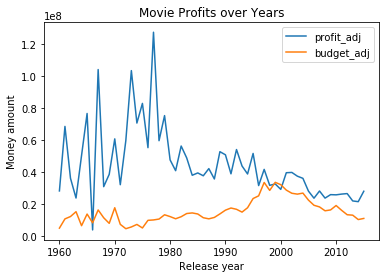

In [159]:
df.groupby('release_year').mean()['profit_adj'].plot()
df.groupby('release_year').mean()['budget_adj'].plot()
plt.title ('Movie Profits over Years')
plt.xlabel('Release year')
plt.ylabel('Money amount')
plt.legend();

The graph demonstrates that the best profits have been taken especially past years. Between years 1960 - 1985, the investments in movie sector returned multiplicative scales. Movie-makers tried to spend more to understand the system responce but the returns have not even increased as a result of that enterprice. Profit curve acts like saturated in recent years. 

There is a point that I need to highlight. It was not a handicap to investigate for the first question but I would like to check the profit share of last 5-10 year intervals. When I used "query" function, I realized that almost one-third of budget_adj data is given as null. Another one-third movies have null values for the revenue_adj data. This was understood during the functional trial of the "query" command below:

In [160]:
df.query('release_year>2009 & release_year<=2015')

,imdb_id,runtime,genres,vote_average,release_year,budget_adj,revenue_adj,profit_adj
0,tt0369610,124,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
1,tt1392190,120,Action|Adventure|Science Fiction|Thriller,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08
2,tt2908446,119,Adventure|Science Fiction|Thriller,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08
3,tt2488496,136,Action|Adventure|Science Fiction|Fantasy,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09
4,tt2820852,137,Action|Crime|Thriller,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09
5,tt1663202,156,Western|Drama|Adventure|Thriller,7.2,2015,1.241999e+08,4.903142e+08,3.661143e+08
6,tt1340138,125,Science Fiction|Action|Thriller|Adventure,5.8,2015,1.425999e+08,4.053551e+08,2.627551e+08
7,tt3659388,141,Drama|Adventure|Science Fiction,7.6,2015,9.935996e+07,5.477497e+08,4.483897e+08
8,tt2293640,91,Family|Animation|Adventure|Comedy,6.5,2015,6.807997e+07,1.064192e+09,9.961120e+08
9,tt2096673,94,Comedy|Animation|Family,8.0,2015,1.609999e+08,7.854116e+08,6.244116e+08


In [161]:
df.drop(df.index[df['budget_adj']== 0], inplace = True)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5168 entries, 0 to 10865
Data columns (total 8 columns):
imdb_id         5167 non-null object
runtime         5168 non-null int64
genres          5168 non-null object
vote_average    5168 non-null float64
release_year    5168 non-null int64
budget_adj      5168 non-null float64
revenue_adj     5168 non-null float64
profit_adj      5168 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 363.4+ KB


In paralel I perform the same steps on .csv file to check if the cleaned data includes the remaining information as intended.

In [163]:
df.drop(df.index[df['revenue_adj']== 0], inplace = True)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 8 columns):
imdb_id         3854 non-null object
runtime         3854 non-null int64
genres          3854 non-null object
vote_average    3854 non-null float64
release_year    3854 non-null int64
budget_adj      3854 non-null float64
revenue_adj     3854 non-null float64
profit_adj      3854 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 271.0+ KB


Also 3854 lines are remained in .csv file after cleaning in order to solve for the analysis of this second question.

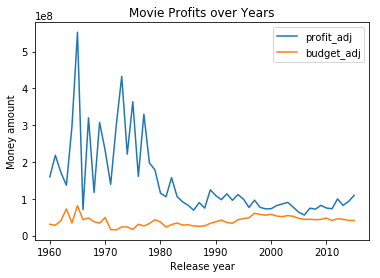

In [165]:
df.groupby('release_year').mean()['profit_adj'].plot()
df.groupby('release_year').mean()['budget_adj'].plot()
plt.title ('Movie Profits over Years')
plt.xlabel('Release year')
plt.ylabel('Money amount')
plt.legend();

The plot above indicates the relation between the budgets and obtained profits year by year correctly in comparison
to first plot for Q4. The main difference with respect to the initial plot is that mean profit is observed never less than mean budget.

<a id='conclusions'></a>
## Conclusions

I have to assess the limitations that I faced, from two different approaches at that section. 

First of all, the data is pretty sufficient to perform investigation if superficial observation is required. Especially if answers to single-variable exploration are searched like how many movie is filmed based on years or their runtime is investigated, the investigation success is highly satisfactory. These informations are more likely to be present at many sources. 

But, if the investigation is deepened to deal with multiple-variable explorations and enlighten the relations between budget and revenue, missing values are encountered for almost two thirds of entire data. This affects the precision and profitability of deductions totally. And more critical point is that missing objects can be detected easily, but missing in other words zero integers should be post-processed to understand whether these data is given zero intentionally or really missing part of the dataset.et.   

And also during the best rated genre investigation in this study, the votecount is not considered. The involvement of vote density/count genre by genre may increase the precision of statements. 

Additionally, there was no data available for the years as of 2015. Therefore, this study does not involve the state of affairs in movie sector for near today. 

However, the dataset was beneficial to understand basic relations from the movie production point of view.

The data is purified from that missing data as far as possible. There was no data available for the years as of 2015. The investigation is done after posing some questions and selecting the related columns regardingly. The classification of the movies can be deep-dived by considering the other related information like total vote amount. Comments and details are discussed right below the questions and code-sections. 

To sum up, the amount of producted films increases exponentially year by year. In 2010, there 3 times more films have been released in comparison to 2000's.

Average runtime has been reduced below 100 minutes and average movie brings profit at least more than it' s production budget.




## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [166]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0